# Parte de Data Science
Autores:
Júlio Limoli,
Marcos Ferreira,
Victor Araki

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, r2_score, accuracy_score, recall_score,
                            roc_auc_score, confusion_matrix, classification_report, precision_score, roc_curve)
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

sns.set()
pio.templates.default = 'plotly_dark'

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Importando DataFrame

In [2]:
df = pd.read_csv('./bases/application_splitado_07.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Flag_Treino
0,456162,False,Cash loans,F,False,False,0,112500.0,700830.0,22738.5,...,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,True
1,134978,False,Cash loans,F,False,False,0,90000.0,375322.5,14422.5,...,False,False,False,0.0,0.0,0.0,1.0,0.0,3.0,True
2,318952,False,Cash loans,M,True,False,0,180000.0,544491.0,16047.0,...,False,False,False,0.0,0.0,0.0,1.0,1.0,3.0,False
3,361264,False,Cash loans,F,False,True,0,270000.0,814041.0,28971.0,...,False,False,False,0.0,0.0,0.0,0.0,1.0,4.0,True
4,260639,False,Cash loans,F,False,True,0,144000.0,675000.0,21906.0,...,False,False,False,0.0,0.0,0.0,10.0,0.0,0.0,True


In [3]:
df_train = df[df['Flag_Treino'] == True]
df_test = df[df['Flag_Treino'] == False]

print(df_train.shape)
print(df_test.shape)

(172206, 90)
(73802, 90)


# Conversão de Variáveis Categóricas

In [30]:
df_dummies = pd.get_dummies(df, drop_first = True)
df_dummies.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,456162,False,False,False,0,112500.0,700830.0,22738.5,585000.0,0.019689,...,0,0,0,0,0,0,0,0,0,0
1,134978,False,False,False,0,90000.0,375322.5,14422.5,324000.0,0.025164,...,0,0,0,0,0,0,0,0,0,0
2,318952,False,True,False,0,180000.0,544491.0,16047.0,454500.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
3,361264,False,False,True,0,270000.0,814041.0,28971.0,679500.0,0.046220,...,0,0,0,0,0,0,0,0,0,1
4,260639,False,False,True,0,144000.0,675000.0,21906.0,675000.0,0.026392,...,0,0,0,0,0,0,0,1,0,0


## Analise Exploratória

In [3]:
df.shape

(246008, 89)

In [11]:
df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,246008.000000,246008.000000,2.460080e+05,2.460080e+05,245998.000000,2.457820e+05,246008.000000,246008.000000,246008.000000,246008.000000,...,245195.000000,245195.000000,245195.000000,246007.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000
mean,278280.072908,0.415527,1.689122e+05,5.996283e+05,27129.162648,5.389289e+05,0.020882,-16042.794393,63963.755699,-4988.033300,...,0.144045,1.406803,0.100691,-962.705390,0.006291,0.006944,0.034487,0.267403,0.264109,1.900040
std,102790.909988,0.719922,2.603818e+05,4.030672e+05,14504.965232,3.699738e+05,0.013852,4365.973763,141400.318322,3520.987047,...,0.449464,2.402398,0.364917,826.831325,0.083236,0.109538,0.204179,0.916640,0.611269,1.868217
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-23738.000000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189165.500000,0.000000,1.125000e+05,2.700000e+05,16561.125000,2.385000e+05,0.010006,-19691.000000,-2758.000000,-7481.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278392.500000,0.000000,1.485000e+05,5.147775e+05,24930.000000,4.500000e+05,0.018850,-15763.000000,-1215.000000,-4503.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367272.250000,1.000000,2.025000e+05,8.086500e+05,34599.375000,6.795000e+05,0.028663,-12418.000000,-289.000000,-2018.000000,...,0.000000,2.000000,0.000000,-273.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,19.000000,23.000000



# Preenchendo os Valores Omissos – Imputação (Data Cleaning)

In [28]:
#Criando um Dataframe com as colunas e sua respectiva quantidade de valores nulos
cols_w_null_values = pd.DataFrame(df.isnull().sum(), columns = ['Null'])
cols_w_null_values = cols_w_null_values[cols_w_null_values['Null'] != 0]
cols_w_null_values

,Null
AMT_ANNUITY,10
AMT_GOODS_PRICE,226
NAME_TYPE_SUITE,1048
OWN_CAR_AGE,162359
OCCUPATION_TYPE,77237
CNT_FAM_MEMBERS,1
EXT_SOURCE_1,138803
EXT_SOURCE_2,544
EXT_SOURCE_3,48728
APARTMENTS_MEDI,124955


In [29]:
#Removendo linhas com entradas nulas em colunas que apresentam menos do que 1000 observações nulas ()
col_index = cols_w_null_values[cols_w_null_values['Null'] < 1000].index

for col in col_index:
    df = df.dropna(subset=list(col_index), axis=0)

#Passando por cada coluna que apresenta valores nulos e fazendo a inserção de dados
for col in cols_w_null_values.index:
    if (col[0:14] == 'AMT_REQ_CREDIT'):
        df[col].fillna(0, inplace=True)  
    elif (df[col].dtypes == int) or (df[col].dtypes == float): #Inserindo a mediana para colunas numéricas
        df[col].fillna(df[col].median(), inplace=True)  
    else: #Inserindo a moda para os demais tipos de coluna
        df[col].fillna(df[col].mode()[0], inplace=True)

# Balanceamento de Amostras

In [15]:
#É possível ver que existe um desbalanceamento na variável de estudo.
df_dummies['TARGET'].value_counts()

False    224541
True      19878
Name: TARGET, dtype: int64

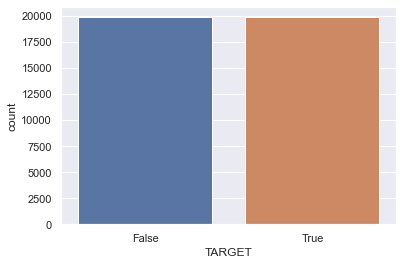

In [16]:
#Para contornar esse problema utilizaremos o RandomUnderSampler para fazer o balanceamento de amostras.
X = df_dummies.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df_dummies['TARGET']

X_under, y_under = RandomUnderSampler(random_state=42).fit_resample(X, y)

sns.countplot(x=y_under)

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

# Seleção de Features

### Testando Modelos usando todas as features

In [56]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
lr_model.fit(X = X_train, y = y_train)

y_proba_lr = lr_model.predict_proba(X_test)
roc_auc_lr = roc_auc_score(y_true = y_test, y_score = y_proba_lr[:,1])

#Treinando um modelo de XGB Classifier utilizando todas as features:
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
xgb_model.fit(X = X_train, y = y_train)

y_proba_xgb = xgb_model.predict_proba(X = X_test)
roc_auc_xgb = roc_auc_score(y_score = y_proba_xgb[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
rfc_model = RandomForestClassifier(max_depth=5, random_state = 42)
rfc_model.fit(X = X_train, y = y_train)

y_proba_rfc = rfc_model.predict_proba(X = X_test)
roc_auc_rfc = roc_auc_score(y_score = y_proba_rfc[:,1], y_true = y_test)

#Imprimindo os Resultados
print(f'ROC_AUC para logistic regression: {roc_auc_lr}')
print(f'ROC_AUC para XGB classifier: {roc_auc_xgb}')
print(f'ROC_AUC para Random Forest Classifier: {roc_auc_rfc}')

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para logistic regression: 0.6026156814916306
ROC_AUC para XGB classifier: 0.7333098876977111
ROC_AUC para Random Forest Classifier: 0.7157812803948991


# Seleção de Features - Logistic Regression (20 features)

In [ ]:
model = LogisticRegression(max_iter=10000, random_state = 42)
rfe = RFE(model, n_features_to_select = 20)
fit = rfe.fit(X_train, y_train)

features_lr_20 = rfe.get_feature_names_out()

print(f"Número de Features: {rfe.n_features_to_select}")
print(f"Features Selecionadas: {features_lr_20}")

### Testando Modelos usando todas as 20 features encontradas

In [58]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
lr_model.fit(X = X_train[features_lr_20], y = y_train)

y_proba_lr = lr_model.predict_proba(X_test[features_lr_20])
roc_auc_lr = roc_auc_score(y_true = y_test, y_score = y_proba_lr[:,1])

#Treinando um modelo de XGB Classifier utilizando todas as features:
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
xgb_model.fit(X = X_train[features_lr_20], y = y_train)

y_proba_xgb = xgb_model.predict_proba(X = X_test[features_lr_20])
roc_auc_xgb = roc_auc_score(y_score = y_proba_xgb[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
rfc_model = RandomForestClassifier(max_depth=5, random_state = 42)
rfc_model.fit(X = X_train[features_lr_20], y = y_train)

y_proba_rfc = rfc_model.predict_proba(X = X_test[features_lr_20])
roc_auc_rfc = roc_auc_score(y_score = y_proba_rfc[:,1], y_true = y_test)

#Imprimindo os Resultados
print(f'ROC_AUC para logistic regression: {roc_auc_lr}')
print(f'ROC_AUC para XGB classifier: {roc_auc_xgb}')
print(f'ROC_AUC para Random Forest Classifier: {roc_auc_rfc}')

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

ROC_AUC para logistic regression: 0.6026192244876588
ROC_AUC para XGB classifier: 0.6879153776206712
ROC_AUC para Random Forest Classifier: 0.6860020051107998


# Seleção de Features - Logistic Regression (15 features)

In [17]:
model = LogisticRegression(max_iter=10000, random_state = 42)
rfe = RFE(model, n_features_to_select = 15)
fit = rfe.fit(X_train, y_train)

features_lr_15 = rfe.get_feature_names_out()

print(f"Número de Features: {rfe.n_features_to_select}")
print(f"Features Selecionadas: {features_lr_15}")

Número de Features: 15
Features Selecionadas: ['AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE'
 'REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY'
 'HOUR_APPR_PROCESS_START' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DAYS_LAST_PHONE_CHANGE'
 'AMT_REQ_CREDIT_BUREAU_YEAR']


### Testando Modelos usando todas as 15 features encontradas

In [60]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
lr_model.fit(X = X_train[features_lr_15], y = y_train)

y_proba_lr = lr_model.predict_proba(X_test[features_lr_15])
roc_auc_lr = roc_auc_score(y_true = y_test, y_score = y_proba_lr[:,1])

#Treinando um modelo de XGB Classifier utilizando todas as features:
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
xgb_model.fit(X = X_train[features_lr_15], y = y_train)

y_proba_xgb = xgb_model.predict_proba(X = X_test[features_lr_15])
roc_auc_xgb = roc_auc_score(y_score = y_proba_xgb[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
rfc_model = RandomForestClassifier(max_depth=5, random_state = 42)
rfc_model.fit(X = X_train[features_lr_15], y = y_train)

y_proba_rfc = rfc_model.predict_proba(X = X_test[features_lr_15])
roc_auc_rfc = roc_auc_score(y_score = y_proba_rfc[:,1], y_true = y_test)

#Imprimindo os Resultados
print(f'ROC_AUC para logistic regression: {roc_auc_lr}')
print(f'ROC_AUC para XGB classifier: {roc_auc_xgb}')
print(f'ROC_AUC para Random Forest Classifier: {roc_auc_rfc}')

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

ROC_AUC para logistic regression: 0.6025957169902012
ROC_AUC para XGB classifier: 0.6413521709370735
ROC_AUC para Random Forest Classifier: 0.638121380344504


# Seleção de Features - Logistic Regression (10 features)

In [ ]:
model = LogisticRegression(max_iter=10000, random_state = 42)
rfe = RFE(model, n_features_to_select = 10)
fit = rfe.fit(X_train, y_train)

features_lr_10 = rfe.get_feature_names_out()

print(f"Número de Features: {rfe.n_features_to_select}")
print(f"Features Selecionadas: {features_lr_10}")

### Testando Modelos usando todas as 10 features encontradas

In [62]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
lr_model.fit(X = X_train[features_lr_10], y = y_train)

y_proba_lr = lr_model.predict_proba(X_test[features_lr_10])
roc_auc_lr = roc_auc_score(y_true = y_test, y_score = y_proba_lr[:,1])

#Treinando um modelo de XGB Classifier utilizando todas as features:
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
xgb_model.fit(X = X_train[features_lr_10], y = y_train)

y_proba_xgb = xgb_model.predict_proba(X = X_test[features_lr_10])
roc_auc_xgb = roc_auc_score(y_score = y_proba_xgb[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
rfc_model = RandomForestClassifier(max_depth=5, random_state = 42)
rfc_model.fit(X = X_train[features_lr_10], y = y_train)

y_proba_rfc = rfc_model.predict_proba(X = X_test[features_lr_10])
roc_auc_rfc = roc_auc_score(y_score = y_proba_rfc[:,1], y_true = y_test)

#Imprimindo os Resultados
print(f'ROC_AUC para logistic regression: {roc_auc_lr}')
print(f'ROC_AUC para XGB classifier: {roc_auc_xgb}')
print(f'ROC_AUC para Random Forest Classifier: {roc_auc_rfc}')

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

ROC_AUC para logistic regression: 0.6026127571139563
ROC_AUC para XGB classifier: 0.63700907642473
ROC_AUC para Random Forest Classifier: 0.6333150672204763


In [63]:
print('A partir da análise dos resultados, podemos ver que 20 é uma boa quantidade de features para o nosso modelo, tendo em vista que o resultado final não é muito impactado e que a redução diminui a complexidade do problema.')

A partir da análise dos resultados, podemos ver que 20 é uma boa quantidade de features para o nosso modelo, tendo em vista que o resultado final não é muito impactado e que a redução diminui a complexidade do problema.


# Seleção de Features - Random Forest (20 features)

In [22]:
model = RandomForestClassifier(max_depth=5, random_state = 42)
rfe = RFE(model, n_features_to_select = 20)
fit = rfe.fit(X_train, y_train)

features_rfc_20 = rfe.get_feature_names_out()

print(f"Número de Features: {rfe.n_features_to_select}")
print(f"Features Selecionadas: {features_rfc_20}")

Número de Features: 20
Features Selecionadas: ['AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_ID_PUBLISH' 'FLAG_EMP_PHONE' 'REGION_RATING_CLIENT_W_CITY'
 'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'LIVINGAREA_MEDI'
 'DAYS_LAST_PHONE_CHANGE' 'CODE_GENDER_F' 'CODE_GENDER_M'
 'NAME_INCOME_TYPE_Pensioner' 'NAME_INCOME_TYPE_Working'
 'NAME_EDUCATION_TYPE_Higher education'
 'NAME_EDUCATION_TYPE_Secondary / secondary special'
 'ORGANIZATION_TYPE_XNA']


### Testando Modelos usando todas as 20 features encontradas

In [41]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
lr_model.fit(X = X_train[features_rfc_20], y = y_train)

y_proba_lr = lr_model.predict_proba(X_test[features_rfc_20])
roc_auc_lr = roc_auc_score(y_true = y_test, y_score = y_proba_lr[:,1])

#Treinando um modelo de XGB Classifier utilizando todas as features:
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
xgb_model.fit(X = X_train[features_rfc_20], y = y_train)

y_proba_xgb = xgb_model.predict_proba(X = X_test[features_rfc_20])
roc_auc_xgb = roc_auc_score(y_score = y_proba_xgb[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
rfc_model = RandomForestClassifier(max_depth=5, random_state = 42)
rfc_model.fit(X = X_train[features_rfc_20], y = y_train)

y_proba_rfc = rfc_model.predict_proba(X = X_test[features_rfc_20])
roc_auc_rfc = roc_auc_score(y_score = y_proba_rfc[:,1], y_true = y_test)

#Imprimindo os Resultados
print(f'ROC_AUC para logistic regression: {roc_auc_lr}')
print(f'ROC_AUC para XGB classifier: {roc_auc_xgb}')
print(f'ROC_AUC para Random Forest Classifier: {roc_auc_rfc}')

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

ROC_AUC para logistic regression: 0.6013576367114226
ROC_AUC para XGB classifier: 0.7348024169531573
ROC_AUC para Random Forest Classifier: 0.7300771006549988


In [67]:
print('Podemos ver uma melhora ascentuda no resultado dos modelos quando utilizamos a feature selection da Random Forest Classifier.')

Podemos ver uma melhora ascentuda no resultado dos modelos quando utilizamos a feature selection da Random Forest Classifier.


# Seleção de Features - XGB Classifier (20 features)

In [ ]:
model = XGBClassifier(random_state = 42, n_estimator = 10, verbosity = 0)
rfe = RFE(model, n_features_to_select = 20)
fit = rfe.fit(X_train, y_train)

features_xgbc_20 = rfe.get_feature_names_out()

print(f"Número de Features: {rfe.n_features_to_select}")
print(f"Features Selecionadas: {features_xgbc_20}")

In [69]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
lr_model.fit(X = X_train[features_xgbc_20], y = y_train)

y_proba_lr = lr_model.predict_proba(X_test[features_xgbc_20])
roc_auc_lr = roc_auc_score(y_true = y_test, y_score = y_proba_lr[:,1])

#Treinando um modelo de XGB Classifier utilizando todas as features:
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
xgb_model.fit(X = X_train[features_xgbc_20], y = y_train)

y_proba_xgb = xgb_model.predict_proba(X = X_test[features_xgbc_20])
roc_auc_xgb = roc_auc_score(y_score = y_proba_xgb[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
xgbc_model = RandomForestClassifier(max_depth=5, random_state = 42)
xgbc_model.fit(X = X_train[features_xgbc_20], y = y_train)

y_proba_xgbc = xgbc_model.predict_proba(X = X_test[features_xgbc_20])
roc_auc_xgbc = roc_auc_score(y_score = y_proba_xgbc[:,1], y_true = y_test)

#Imprimindo os Resultados
print(f'ROC_AUC para logistic regression: {roc_auc_lr}')
print(f'ROC_AUC para XGB classifier: {roc_auc_xgb}')
print(f'ROC_AUC para Random Forest Classifier: {roc_auc_xgbc}')

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

ROC_AUC para logistic regression: 0.5408670813546685
ROC_AUC para XGB classifier: 0.726420250730518
ROC_AUC para Random Forest Classifier: 0.7323588182162409


In [70]:
print('Os resultados são muito próximos dos resultados encontrados na seleção de features utilizando o random forest classifier. Portanto, optaremos por seguir utilizando as features selecionadas pelo RFC, já que a necessidade de processamento necessária para realizar essa seleção é muito menor.')

Os resultados são muito próximos dos resultados encontrados na seleção de features utilizando o random forest classifier. Portanto, optaremos por seguir utilizando as features selecionadas pelo RFC, já que a necessidade de processamento necessária para realizar essa seleção é muito menor.


# Criação de Modelos

In [38]:
features_rfc_20 = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 
 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'LIVINGAREA_MEDI', 
 'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 
 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working', 
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'ORGANIZATION_TYPE_XNA']

In [40]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
lr_model.fit(X = X_train[features_rfc_20], y = y_train)

y_proba_lr = lr_model.predict_proba(X_test[features_rfc_20])
roc_auc_lr = roc_auc_score(y_true = y_test, y_score = y_proba_lr[:,1])

#Treinando um modelo de XGB Classifier utilizando todas as features:
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
xgb_model.fit(X = X_train[features_rfc_20], y = y_train)

y_proba_xgb = xgb_model.predict_proba(X = X_test[features_rfc_20])
roc_auc_xgb = roc_auc_score(y_score = y_proba_xgb[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
rfc_model = RandomForestClassifier(max_depth=5, random_state = 42)
rfc_model.fit(X = X_train[features_rfc_20], y = y_train)

y_proba_rfc = rfc_model.predict_proba(X = X_test[features_rfc_20])
roc_auc_rfc = roc_auc_score(y_score = y_proba_rfc[:,1], y_true = y_test)

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
ada_model = AdaBoostClassifier(random_state = 42)
ada_model.fit(X = X_train[features_rfc_20], y = y_train)

y_proba_ada = ada_model.predict_proba(X = X_test[features_rfc_20])
roc_auc_ada = roc_auc_score(y_score = y_proba_ada[:,1], y_true = y_test)

#Imprimindo os Resultados
print(f'ROC_AUC para logistic regression: {roc_auc_lr}')
print(f'ROC_AUC para XGB classifier: {roc_auc_xgb}')
print(f'ROC_AUC para Random Forest Classifier: {roc_auc_rfc}')
print(f'ROC_AUC para Ada Boost Classifier: {roc_auc_ada}')

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

ROC_AUC para logistic regression: 0.6013576367114226
ROC_AUC para XGB classifier: 0.7348024169531573
ROC_AUC para Random Forest Classifier: 0.7300771006549988
ROC_AUC para Ada Boost Classifier: 0.7370510806109767


In [ ]:
# modelo = RandomForestClassifier(random_state=13)

# grid_search = {
#     'max_depth': np.arange(5,20,1),
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': np.arange(2, 10, 1)
# }

# gscv = GridSearchCV(estimator= modelo,
#                     param_grid= grid_search, 
#                     scoring='roc_auc' ,
#                     cv=3)

# gscv.fit(X_train, y_train)